# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.0 MB/s eta 0:00:

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:04<00:14,  4.87s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:12<00:13,  6.69s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:18<00:06,  6.20s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:25<00:00,  6.40s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:05<00:05,  2.90s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:08<00:02,  2.82s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [11]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [12]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [13]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:04<00:00,  4.93s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:04<00:00,  4.93s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [14]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [15]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index

    num_to_poison = int(len(target_indices) * poison_fraction)

    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)

    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class

    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


--- Applying Model Poisoning ---
Poisoning 11 clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Flipping label from 6 to 0 for 100.0% of samples of malicious clients.
Client 0: Flipped 12985 labels from class 6 to 0.
Client 1: Flipped 12985 labels from class 6 to 0.
Client 2: Flipped 12985 labels from class 6 to 0.
Client 3: Flipped 12986 labels from class 6 to 0.
Client 4: Flipped 12986 labels from class 6 to 0.
Client 5: Flipped 0 labels from class 6 to 0.
Client 6: Flipped 12986 labels from class 6 to 0.
Client 7: Flipped 12986 labels from class 6 to 0.
Client 8: Flipped 12986 labels from class 6 to 0.
Client 9: Flipped 12986 labels from class 6 to 0.
Client 10: Flipped 12986 labels from class 6 to 0.
--- Model Poisoning Applied ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
0     14977
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  0 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8 33 26 22 12 21  9
 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
0     14977
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       

Visualize Data Distribution

STRATIFIED Client

In [21]:
#STRATIFIED Client

In [22]:
#LEAVE_ONE_OUT

In [23]:
#Half begign

In [24]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


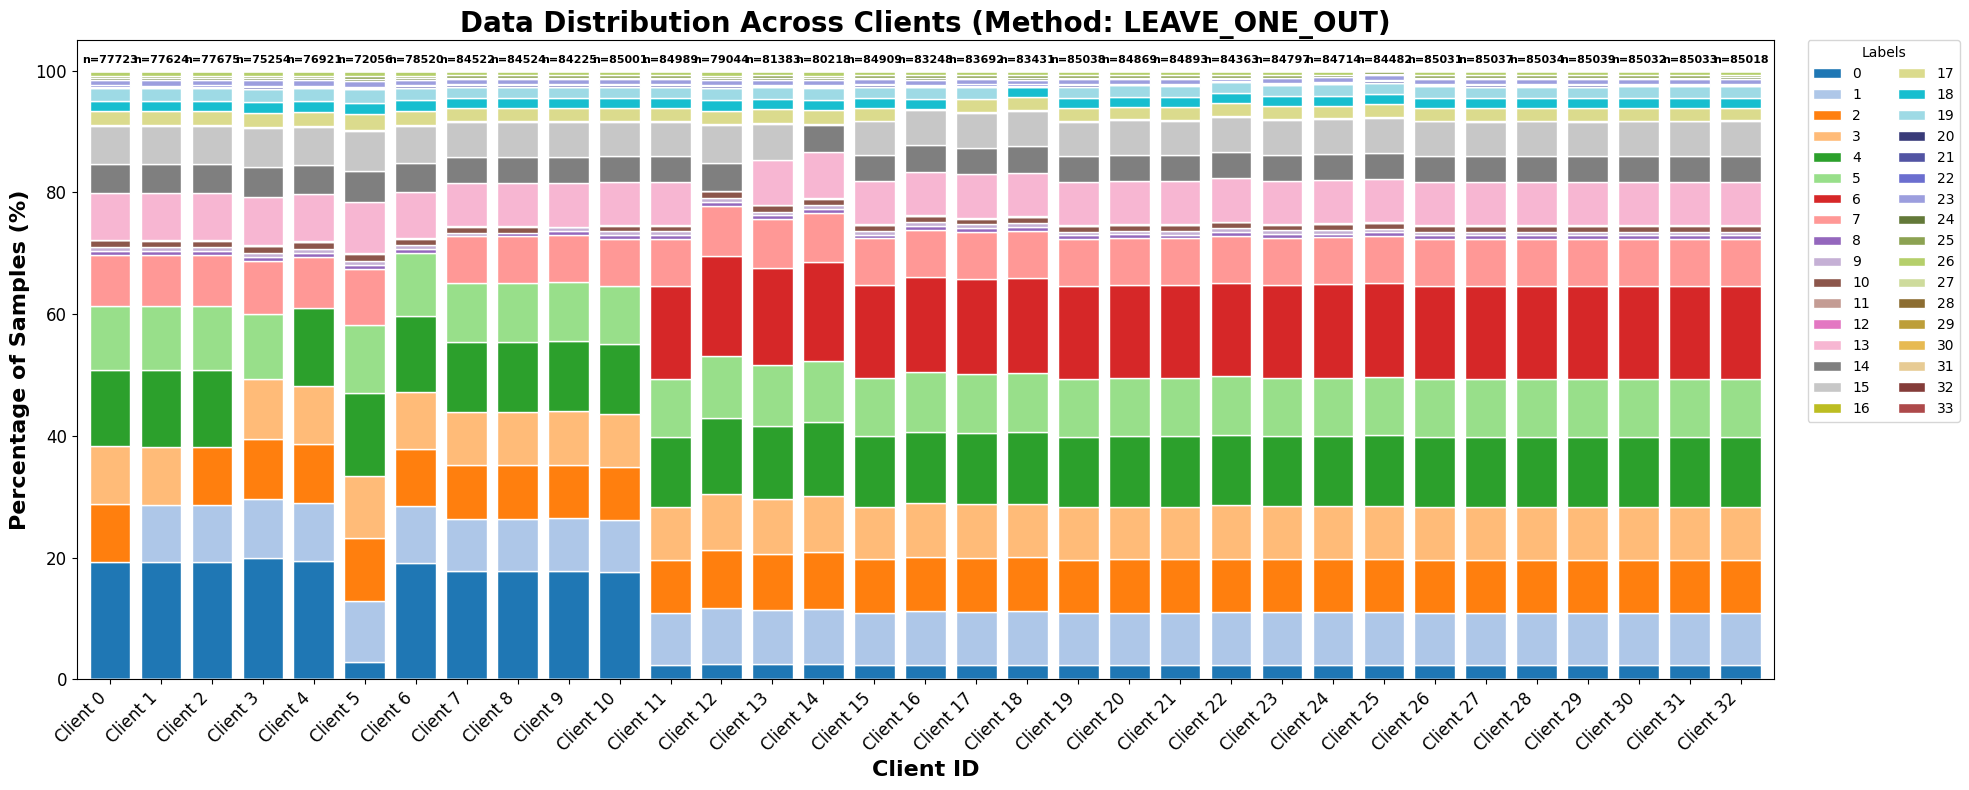

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [26]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [27]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [29]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [30]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [32]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [33]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10, #10,
        min_evaluate_clients=5, #5,
        min_available_clients=10, #10,
        evaluate_fn=get_evaluate_fn(server_model),
        #evaluate_metrics_aggregation_fn=weighted_average,
)
# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-04 11:41:01,979	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3992886067.0, 'memory': 7985772135.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1632) WARNING: All log messages before absl::InitializeLog() 

(ClientAppActor pid=1633) Client ID: 26
Server Evaluating... Evaluation Count: 0


(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


23275/23275 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.0013 - loss: 3.5945
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Prediction:  [[0.02994983 0.03335462 0.04972834 ... 0.05066295 0.0280715  0.03186006]
 [0.01921327 0.0162072  0.05291818 ... 0.07566416 0.0346916  0.02490721]
 [0.02968779 0.02735452 0.04230965 ... 0.037236   0.02439996 0.0284994 ]
 ...
 [0.04599646 0.01384232 0.05951518 ... 0.06965753 0.03052266 0.03860564]
 [0.02948626 0.03440243 0.03762041 ... 0.03994508 0.02732071 0.02997416]
 [0.03001599 0.03301721 0.03697663 ... 0.03979176 0.02796927 0.03044033]] (744790, 34)


INFO :      initial parameters (loss, other metrics): 3.594252824783325, {'accuracy': 0.0013574296608567238}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.0014, Loss: 3.5943
(ClientAppActor pid=1633) Client ID: 17


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Client  17 Training...


(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1632) Client ID: 11
(ClientAppActor pid=1633) Epoch 1/5
   1/2616 ━━━━━━━━━━━━━━━━━━━━ 1:49:43 3s/step - accuracy: 0.0000e+00 - loss: 3.8762
  24/2616 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0851 - loss: 3.4883
  28/2656 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1033 - loss: 3.3852
  46/2616 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1700 - loss: 3.3424
 323/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4838 - loss: 2.0204
 353/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4956 - loss: 1.9522
 382/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5059 - loss: 1.8927
 407/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5140 - loss: 1.8458
(ClientAppActor pid=1632) Client  11 Training...
(ClientAppActor pid=1632) Epoch 1/5
 689/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5845 - loss: 1.5079
 694/2616 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5853 - loss: 1.5034
   1/2656 ━━━━━━━━━━━━━━━━━━━━ 1:31:48 2s/step - accuracy:

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1633) Epoch 1/5


(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  10/2429 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.0208 - loss: 3.4881       
  24/2429 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.0890 - loss: 3.3748
  32/2429 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.1227 - loss: 3.3214
  40/2429 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.1509 - loss: 3.2739
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:35:45 2s/step - accuracy: 0.0000e+00 - loss: 3.7771
  50/2429 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.1814 - loss: 3.2153
  20/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0515 - loss: 3.4743
  59/2429 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.2042 - loss: 3.1614
2646/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7497 - loss: 0.4877 [repeated 12x across cluster]
  73/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2359 - loss: 3.0753
  38/2658 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.1260 - loss: 3.3578
  82/2429 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2542 - loss: 3.0192
  87/2429 ━━━━━━

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1633) Client  13 Training...


(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1633) Epoch 1/5
1987/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7481 - loss: 0.4888 [repeated 58x across cluster]
1917/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7482 - loss: 0.4888 [repeated 6x across cluster]
   1/2544 ━━━━━━━━━━━━━━━━━━━━ 3:11:14 5s/step - accuracy: 0.0000e+00 - loss: 3.4997
  31/2544 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1262 - loss: 3.3167
 237/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4628 - loss: 2.1738
 260/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4772 - loss: 2.0977
(ClientAppActor pid=1632) Client  28 Training complete...
 282/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4893 - loss: 2.0318
 285/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4909 - loss: 2.0233
 290/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4934 - loss: 2.0094
 298/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4974 - loss: 1.9877


(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 27
 307/2544 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5016 - loss: 1.9641
(ClientAppActor pid=1632) Client  27 Training...
 328/2544 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5112 - loss: 1.9120
 354/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5220 - loss: 1.8530
(ClientAppActor pid=1632) Epoch 1/5
 373/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5292 - loss: 1.8133
 397/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5376 - loss: 1.7666
 424/2544 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5463 - loss: 1.7182
 453/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5549 - loss: 1.6706
 480/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5623 - loss: 1.6297
2650/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7481 - loss: 0.4886 [repeated 43x across cluster]
 506/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5688 - loss: 1.5933
 528/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5740 - l

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Epoch 1/5
 978/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7503 - loss: 0.4851 [repeated 5x across cluster]
 833/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7507 - loss: 0.4841 [repeated 20x across cluster]
  12/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0161 - loss: 3.5205       
2152/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7497 - loss: 0.4873 [repeated 51x across cluster]
 642/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5666 - loss: 1.5646
 848/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5939 - loss: 1.3983
 888/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5981 - loss: 1.3730
 895/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5988 - loss: 1.3687
 434/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5215 - loss: 1.8335  [repeated 18x across cluster]
(ClientAppActor pid=1632) Client  27 Training complete...


(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 9
(ClientAppActor pid=1632) Client  9 Training...
(ClientAppActor pid=1632) Epoch 1/5
1239/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6256 - loss: 1.2063 [repeated 67x across cluster]
2340/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7497 - loss: 0.4874
1408/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6349 - loss: 1.1497
1433/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6361 - loss: 1.1423 [repeated 7x across cluster]
   1/2633 ━━━━━━━━━━━━━━━━━━━━ 2:59:26 4s/step - accuracy: 0.0000e+00 - loss: 3.5001
  22/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0690 - loss: 3.4379
  45/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1655 - loss: 3.2952
  65/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2258 - loss: 3.1728
  85/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2702 - loss: 3.0489
 109/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3129 - loss: 2.9038
 133/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Client  32 Training...
1031/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7440 - loss: 0.4962
1044/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7440 - loss: 0.4961
1056/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7440 - loss: 0.4961
(ClientAppActor pid=1633) Epoch 1/5
1071/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4961
1082/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4961
1101/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4961
1115/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4960
1135/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4960
1147/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4960
1159/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4960
1175/2633 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7440 - loss: 0.4959
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 4
(ClientAppActor pid=1632) Client  4 Training...
(ClientAppActor pid=1632) Epoch 1/5
1305/2657 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6270 - loss: 1.1735 [repeated 68x across cluster]
  13/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0154 - loss: 3.5081       
 972/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6035 - loss: 1.3141 [repeated 2x across cluster]
  36/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1043 - loss: 3.3510
  53/2404 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1758 - loss: 3.2398
  76/2404 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.2460 - loss: 3.0893
 104/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3050 - loss: 2.9130
 122/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3349 - loss: 2.8067
 145/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3667 - loss: 2.6809
 168/2404 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3935 - loss: 2.5665
 191/2404 ━━━━━━━━━━━━━━━━━━━━ 10

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Epoch 1/5
1676/2404 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7818 - loss: 0.4331 [repeated 5x across cluster]
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:57:46 3s/step - accuracy: 0.0000e+00 - loss: 3.8027
  12/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.0244 - loss: 3.5564
  22/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.0608 - loss: 3.4828
  35/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.1209 - loss: 3.3928
  46/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.1654 - loss: 3.3171
  56/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.1998 - loss: 3.2496
  66/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2294 - loss: 3.1834
  75/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2531 - loss: 3.1240
  85/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2766 - loss: 3.0570
  92/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.2914 - loss: 3.0104
 101/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.308

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 141/2658 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.3680 - loss: 2.7160
 154/2658 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3826 - loss: 2.6483
 165/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3939 - loss: 2.5937
2402/2404 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7821 - loss: 0.4343 [repeated 37x across cluster]
(ClientAppActor pid=1632) Client ID: 12
(ClientAppActor pid=1632) Client  12 Training...
 178/2658 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.4061 - loss: 2.5327
 192/2658 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.4180 - loss: 2.4710
 205/2658 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.4281 - loss: 2.4171
(ClientAppActor pid=1632) Epoch 1/5
 222/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.4402 - loss: 2.3515
 238/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.4506 - loss: 2.2942
 254/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.4601 - loss: 2.2408
 271/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 8
(ClientAppActor pid=1632) Client  8 Training...
(ClientAppActor pid=1632) Epoch 1/5


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  12/2642 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.0326 - loss: 3.5030   
  36/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1291 - loss: 3.3586
  63/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2169 - loss: 3.1933
  88/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2734 - loss: 3.0484
 115/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3200 - loss: 2.8934
 139/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3531 - loss: 2.7611
2319/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7430 - loss: 0.4906 [repeated 2x across cluster]
 168/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3853 - loss: 2.6155
 189/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4047 - loss: 2.5204
 211/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4224 - loss: 2.4296
 233/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4379 - loss: 2.3472
 256/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4521 - loss: 2.2692
 276/2642 ━━━━━━━━━━━━━━━━━━━━ 10

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1632) Client ID: 23
(ClientAppActor pid=1632) Client  23 Training...
(ClientAppActor pid=1632) Epoch 1/5
2174/2654 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7491 - loss: 0.4905 [repeated 9x across cluster]
2324/2642 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7468 - loss: 0.4902 [repeated 2x across cluster]
2634/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7493 - loss: 0.4903 [repeated 61x across cluster]


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   9/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.0081 - loss: 3.5264       
  29/2650 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0736 - loss: 3.3879
  49/2650 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.1538 - loss: 3.2603
  70/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2135 - loss: 3.1244
  92/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2616 - loss: 2.9800
 114/2650 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2999 - loss: 2.8405
 139/2650 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3350 - loss: 2.6964
 161/2650 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3599 - loss: 2.5830
 185/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3836 - loss: 2.4712
 206/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4017 - loss: 2.3828
 229/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4192 - loss: 2.2953
 249/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4326 - loss: 2.2264
 274/2650 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

(ClientAppActor pid=1632) Client ID: 1
(ClientAppActor pid=1632) Client  1 Training...
(ClientAppActor pid=1632) Epoch 1/5
2642/2648 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7528 - loss: 0.4769 [repeated 67x across cluster]
2648/2648 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7528 - loss: 0.4769 [repeated 10x across cluster]


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  11/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0380 - loss: 3.5303       
  31/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1229 - loss: 3.4205
  51/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2022 - loss: 3.2964
  71/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2566 - loss: 3.1695
  92/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.2999 - loss: 3.0344
 112/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3315 - loss: 2.9096
 132/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3576 - loss: 2.7916
 151/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3790 - loss: 2.6877
 174/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4010 - loss: 2.5735
 189/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4134 - loss: 2.5056
 205/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4254 - loss: 2.4386
 225/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4387 - loss: 2.3619
 248/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1632) Client ID: 20
(ClientAppActor pid=1632) Client  20 Training...
(ClientAppActor pid=1632) Epoch 1/5
2415/2428 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8093 - loss: 0.3807
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8093 - loss: 0.3807


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/2653 ━━━━━━━━━━━━━━━━━━━━ 3:23:32 5s/step - accuracy: 0.0000e+00 - loss: 3.5413
(ClientAppActor pid=1633) Client  2 Training complete...
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8093 - loss: 0.3807 [repeated 17x across cluster]
(ClientAppActor pid=1633) Client ID: 19
(ClientAppActor pid=1633) Client  19 Training...
  15/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.0374 - loss: 3.4767
  27/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.0828 - loss: 3.4014
  42/2653 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.1434 - loss: 3.3098
  52/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.1762 - loss: 3.2499
  63/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2049 - loss: 3.1850
(ClientAppActor pid=1633) Epoch 1/5
  77/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2356 - loss: 3.0991
  89/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2593 - loss: 3.0244
  99/2653 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2770 - loss: 2.9631
 1

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1632) Client ID: 10
(ClientAppActor pid=1632) Client  10 Training...
(ClientAppActor pid=1632) Epoch 1/5


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   8/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.0068 - loss: 3.5141       
  25/2657 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.0680 - loss: 3.4053
2654/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7487 - loss: 0.4871 [repeated 25x across cluster]
  37/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.1192 - loss: 3.3283
  52/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.1747 - loss: 3.2325
  67/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2182 - loss: 3.1351
  79/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2482 - loss: 3.0566
  91/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2741 - loss: 2.9798
  97/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2857 - loss: 2.9426
 110/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3084 - loss: 2.8633
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7487 - loss: 0.4871 [repeated 5x across cluster]
 116/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3179 - loss: 2.8277

(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Epoch 1/5
1485/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7497 - loss: 0.4849 [repeated 5x across cluster]
   1/2641 ━━━━━━━━━━━━━━━━━━━━ 1:33:25 2s/step - accuracy: 0.0000e+00 - loss: 3.5488
  22/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0513 - loss: 3.5524
  43/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1278 - loss: 3.4054
  63/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1877 - loss: 3.2794
2176/2657 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7495 - loss: 0.4859 [repeated 61x across cluster]
  84/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2390 - loss: 3.1432
 104/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2786 - loss: 3.0142
 119/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3031 - loss: 2.9227
 140/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3322 - loss: 2.8013
 161/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3568 - loss: 2.6895
 185/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/ste

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 7
 584/2641 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5484 - loss: 1.6531
(ClientAppActor pid=1632) Client  7 Training...
 609/2641 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5533 - loss: 1.6246
(ClientAppActor pid=1632) Epoch 1/5
 632/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5575 - loss: 1.5999
 653/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5612 - loss: 1.5785
 674/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5647 - loss: 1.5579
 696/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5682 - loss: 1.5374
 712/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5706 - loss: 1.5231
 735/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5740 - loss: 1.5032
 763/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5778 - loss: 1.4804
 777/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5797 - loss: 1.4694 
 817/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5848 - loss: 1.4394 [repeated 5x across 

(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Epoch 1/5
1672/2642 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7474 - loss: 0.4889 [repeated 9x across cluster]
1971/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7474 - loss: 0.4889 [repeated 68x across cluster]
   1/2608 ━━━━━━━━━━━━━━━━━━━━ 1:41:19 2s/step - accuracy: 0.0000e+00 - loss: 3.5567
  25/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0803 - loss: 3.4296
  47/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1710 - loss: 3.2987
  64/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2222 - loss: 3.1915
  86/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2747 - loss: 3.0434
 109/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3157 - loss: 2.8970
 126/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3404 - loss: 2.7948
 147/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3661 - loss: 2.6787
 173/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3925 - loss: 2.5494
 196/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/ste

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client  6 Training...
 527/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5475 - loss: 1.6835
(ClientAppActor pid=1632) Epoch 1/5
 547/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5517 - loss: 1.6585
 567/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5556 - loss: 1.6348
 589/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5597 - loss: 1.6100
 610/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5635 - loss: 1.5876
 634/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5675 - loss: 1.5632
 659/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5714 - loss: 1.5393
 681/2608 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5747 - loss: 1.5192 
 731/2608 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5817 - loss: 1.4770 [repeated 38x across cluster]
  12/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0346 - loss: 3.4666       
  34/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1308 - loss: 3.3455
  58/2454 ━━━━━━━━━━━━

(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 30
(ClientAppActor pid=1632) Client  30 Training...
(ClientAppActor pid=1632) Epoch 1/5


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:24:49 2s/step - accuracy: 0.0000e+00 - loss: 3.6064
  27/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0983 - loss: 3.4168
  58/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2076 - loss: 3.2243
  30/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1116 - loss: 3.4060
2608/2608 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7492 - loss: 0.4976 [repeated 2x across cluster]
(ClientAppActor pid=1633) Client  18 Training complete...
 277/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4600 - loss: 2.1502
 801/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5824 - loss: 1.4259 [repeated 48x across cluster]
(ClientAppActor pid=1633) Client ID: 26
(ClientAppActor pid=1633) Client  26 Training...
(ClientAppActor pid=1633) Epoch 1/5
 721/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5767 - loss: 1.4706
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:16:22 2s/step - accuracy: 0.0000e+00 - loss: 3.6706
1020/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - ac

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

(ClientAppActor pid=1632) Client ID: 14
2211/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7461 - loss: 0.4875
(ClientAppActor pid=1632) Client  14 Training...
(ClientAppActor pid=1632) Epoch 1/5
2274/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7461 - loss: 0.4875 [repeated 13x across cluster]
2556/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7461 - loss: 0.4877


(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  14/2507 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0156 - loss: 3.4623       
  42/2507 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1204 - loss: 3.2945
  73/2507 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2234 - loss: 3.0918
 740/2507 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6093 - loss: 1.3996 [repeated 40x across cluster]
(ClientAppActor pid=1633) Client  26 Training complete...
(ClientAppActor pid=1633) Client ID: 29
(ClientAppActor pid=1633) Client  29 Training...
(ClientAppActor pid=1633) Epoch 1/5
 292/2507 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4831 - loss: 2.0631 [repeated 6x across cluster]
 703/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5683 - loss: 1.5044
 768/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5773 - loss: 1.4520
  15/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0321 - loss: 3.4670       
  43/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1316 - loss: 3.3245
2179/2507 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1632) Client ID: 5
(ClientAppActor pid=1632) Client  5 Training...
1323/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7424 - loss: 0.5008 [repeated 81x across cluster]
(ClientAppActor pid=1632) Epoch 1/5
   1/2252 ━━━━━━━━━━━━━━━━━━━━ 1:19:53 2s/step - accuracy: 0.0000e+00 - loss: 3.5359
  21/2252 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.0795 - loss: 3.4107
1107/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7416 - loss: 0.5022 [repeated 10x across cluster]
  36/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1363 - loss: 3.3090
  43/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1564 - loss: 3.2655
  58/2252 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.1897 - loss: 3.1739
  72/2252 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2146 - loss: 3.0907
  87/2252 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2394 - loss: 3.0020
  99/2252 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2576 - loss: 2.9317
1862/2658 ━━━━━━━━━━━━━━━━━━━━ 2

(ClientAppActor pid=1633) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1633)             entirely in future versions of Flower.
(ClientAppActor pid=1633)         
(ClientAppActor pid=1633) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1633)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1633) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1633) Epoch 1/5
  18/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0374 - loss: 3.4529        
1571/2252 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5944 - loss: 1.1774 [repeated 49x across cluster]
1900/2252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6056 - loss: 1.1085 [repeated 5x across cluster]
(ClientAppActor pid=1632) Epoch 2/5
  19/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7029 - loss: 0.5992   
 823/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6938 - loss: 0.6080 [repeated 93x across cluster]
 626/2252 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6932 - loss: 0.6092 [repeated 2x across cluster]
2106/2602 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6679 - loss: 0.9726
1906/2252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6933 - loss: 0.6069 [repeated 93x across cluster]
(ClientAppActor pid=1633) Epoch 2/5
   1/2602 ━━━━━━━━━━━━━━━━━━━━ 6:04 140ms/step - accuracy: 0.8125 - loss: 0.4792
  12/2602 ━━━━━━━━━━━━━━━━━━━━ 26s 1

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1632) Client ID: 22


(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1632) Client  22 Training...
(ClientAppActor pid=1632) Epoch 1/5
1995/2602 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7518 - loss: 0.4838 [repeated 77x across cluster]
1773/2602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7514 - loss: 0.4842 [repeated 5x across cluster]
   1/2602 ━━━━━━━━━━━━━━━━━━━━ 2:26 56ms/step - accuracy: 0.7500 - loss: 0.5535
  15/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7555 - loss: 0.4716
  21/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7597 - loss: 0.4610
  29/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7638 - loss: 0.4533
  40/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7654 - loss: 0.4518
  66/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7661 - loss: 0.4527
  89/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7661 - loss: 0.4546
 119/2602 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7653 - loss: 0.4579
 148/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7651 - loss: 0.459

INFO :      aggregate_fit: received 33 results and 0 failures


(ClientAppActor pid=1632) Client  22 Training complete...
Server Evaluating... Evaluation Count: 1
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.7393 - loss: 0.5429
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


INFO :      fit progress: (1, 0.543384850025177, {'accuracy': 0.7387182712554932}, 1291.486615756)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[2.3418399e-05 6.0435303e-07 1.1879388e-06 ... 9.8540056e-07
  2.4121556e-07 3.2038687e-07]
 [1.1269681e-10 4.4851271e-12 9.9998719e-01 ... 1.8947311e-11
  3.9097024e-11 1.7723042e-13]
 [4.5976594e-05 7.4199488e-06 4.7087236e-05 ... 1.2188428e-07
  1.0142142e-08 8.5627806e-07]
 ...
 [2.8309208e-07 2.2469203e-08 4.9342925e-06 ... 3.4720453e-14
  1.0868966e-11 2.1186668e-09]
 [5.1936272e-06 1.5577174e-07 6.2891822e-06 ... 5.8042882e-09
  3.4182926e-10 5.3647852e-08]
 [1.3913520e-05 5.6708848e-07 7.8918765e-06 ... 2.2875602e-08
  1.7910995e-09 1.8665850e-07]] (744790, 34)
Server evaluation complete - Accuracy: 0.7387, Loss: 0.5434


(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1632)             entirely in future versions of Flower.
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1632) Client ID: 8
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7498 - loss: 0.4821 [repeated 22x across cluster]
(ClientAppActor pid=1632) Client  8 Evaluating...


(ClientAppActor pid=1633) 
(ClientAppActor pid=1633)         


  19/2642 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5908 - loss: 0.9432     
   1/2653 ━━━━━━━━━━━━━━━━━━━━ 21:18 482ms/step - accuracy: 0.7188 - loss: 0.6183
  38/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7281 - loss: 0.5569
 609/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5810 - loss: 0.9684
 624/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5810 - loss: 0.9681
 786/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5812 - loss: 0.9664
 837/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5812 - loss: 0.9662
 854/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5812 - loss: 0.9662
(ClientAppActor pid=1633) Client ID: 21
1459/2642 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5811 - loss: 0.9649 [repeated 75x across cluster]
(ClientAppActor pid=1633) Client  21 Evaluating...
1784/2642 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5811 - loss: 0.9646
2133/2642 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5813 - loss: 0.9643
2193/2642 ━━━━━━━━━━━━

(ClientAppActor pid=1632) 
(ClientAppActor pid=1632)         
(ClientAppActor pid=1632) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1632)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1632)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1632) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1632)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1632) Client ID: 17


(ClientAppActor pid=1632) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1632) Client  17 Evaluating...
2636/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7386 - loss: 0.5410 [repeated 76x across cluster]
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff36e23fa0da0f8a6f8b9ac8a901000000 Worker ID: c8d048f2508c8b406c5a3246a5e276c61db7214232fb098339719cc8 Node ID: 9c524f64b71b567fa138c4911a1ff11173c7bb8f0475202921c80138 Worker IP address: 172.28.0.12 Worker port: 41231 Worker PID: 1632 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


ERROR :     The actor died unexpectedly before finishing this task.
	class_name: ClientAppActor
	actor_id: 36e23fa0da0f8a6f8b9ac8a901000000
	pid: 1632
	namespace: 16033d2b-6d0e-45f3-8946-6d65a83318a6
	ip: 172.28.0.12
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_tran

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7386 - loss: 0.5410 [repeated 5x across cluster]
(ClientAppActor pid=1633) Client 21 evaluation complete - Accuracy: 0.738942, Loss: 0.541069
(ClientAppActor pid=18892) Client ID: 16


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=18892) Client  16 Training...
(ClientAppActor pid=18892) Epoch 1/5
  17/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7339 - loss: 0.5229    
  55/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7487 - loss: 0.5052
  88/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7511 - loss: 0.4988
 107/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7521 - loss: 0.4965


(raylet) [2025-09-04 12:06:02,013 E 1485 1485] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 9c524f64b71b567fa138c4911a1ff11173c7bb8f0475202921c80138, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


 137/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7531 - loss: 0.4944
 169/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7539 - loss: 0.4931
 199/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7541 - loss: 0.4931
 225/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7542 - loss: 0.4933
 258/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7548 - loss: 0.4932
 288/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7553 - loss: 0.4930
 319/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7557 - loss: 0.4927
 351/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7561 - loss: 0.4924
 388/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7564 - loss: 0.4923
 413/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7566 - loss: 0.4922
 442/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7568 - loss: 0.4919
 470/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7570 - loss: 0.4916
 500/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7572 - loss: 0.4914

INFO :      aggregate_fit: received 1 results and 32 failures


2602/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7628 - loss: 0.4638
(ClientAppActor pid=18892) Client  16 Training complete...
Server Evaluating... Evaluation Count: 2
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7474 - loss: 0.8842
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


INFO :      fit progress: (2, 0.8847122192382812, {'accuracy': 0.7472938895225525}, 1510.300160537)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[2.9986261e-06 5.3013056e-09 2.9247917e-06 ... 1.5032616e-11
  1.3552450e-11 1.6977503e-09]
 [2.2797576e-13 7.0788129e-14 9.9991244e-01 ... 9.2254752e-17
  5.8787500e-21 1.8912991e-16]
 [3.6554045e-06 3.2055832e-05 1.4998611e-05 ... 1.8431379e-10
  2.0987967e-09 5.3811652e-07]
 ...
 [7.3658959e-15 6.1122538e-22 1.1580439e-08 ... 7.9460950e-32
  2.4033892e-32 9.8780083e-21]
 [1.3640677e-06 1.5564418e-10 1.0389520e-06 ... 4.6286742e-11
  2.5644513e-17 4.1400847e-09]
 [7.3874749e-06 2.6272022e-09 1.9771708e-06 ... 9.6647890e-10
  5.8533509e-15 6.1577964e-08]] (744790, 34)
Server evaluation complete - Accuracy: 0.7473, Loss: 0.8847


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulatio

(ClientAppActor pid=18892) Client ID: 6


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 9c524f64b71b567fa138c4911a1ff11173c7bb8f0475202921c80138) where the task (actor ID: e11faa7238eb6db2e54ed95601000000, name=ClientAppActor.__init__, pid=1633, memory used=0.57GB) was running was 12.12GB / 12.67GB (0.956087), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 537f979db0b354e376b8a9f97e0e1a4f8fb524f9fca16b601eba526d) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-537f979db0b354e376b8a9f97e0e1a4f8fb524f9fca16b601eba526d*out -ip 172.28.0.12. Top 10 memory

(ClientAppActor pid=18892) Client  6 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  11/2454 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5951 - loss: 4.3682   
  20/2454 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6003 - loss: 4.3922
  29/2454 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6078 - loss: 4.3261
  38/2454 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6100 - loss: 4.3204 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  48/2454 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6114 - loss: 4.3086
  54/2454 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.6118 - loss: 4.3014
  72/2454 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6115 - loss: 4.3095
  79/2454 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.6113 - loss: 4.3160
  83/2454 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6112 - loss: 4.3238
  89/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6110 - loss: 4.3298
  98/2454 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.6111 - loss: 4.3319
 111/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6114 - loss: 4.3311
 117/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6116 - loss: 4.3294


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 120/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.6117 - loss: 4.3286
 126/2454 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.6119 - loss: 4.3274
 135/2454 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.6119 - loss: 4.3290
 139/2454 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6119 - loss: 4.3292


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 145/2454 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.6118 - loss: 4.3286
 147/2454 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.6119 - loss: 4.3281
 149/2454 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.6119 - loss: 4.3274
 151/2454 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.6119 - loss: 4.3269
 170/2454 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.6120 - loss: 4.3229
 213/2454 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6115 - loss: 4.3371
 248/2454 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6112 - loss: 4.3406
 282/2454 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.6111 - loss: 4.3395
 323/2454 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.6109 - loss: 4.3397
 355/2454 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6107 - loss: 4.3397 
 393/2454 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6107 - loss: 4.3411
 421/2454 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6107 - loss: 4.3433
 458/2454 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2403/2454 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6086 - loss: 4.3942
2454/2454 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6086 - loss: 4.3940
(ClientAppActor pid=18892) Client 6 evaluation complete - Accuracy: 0.608711, Loss: 4.379983


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=18892) Client ID: 11


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=18892) Client  11 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=18892) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   8/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7211 - loss: 0.6861   
  10/2656 ━━━━━━━━━━━━━━━━━━━━ 1:08 26ms/step - accuracy: 0.7196 - loss: 0.7054
  14/2656 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.7204 - loss: 0.7220 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  22/2656 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.7242 - loss: 0.7458 
  36/2656 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7282 - loss: 0.7591
  40/2656 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7292 - loss: 0.7579
  52/2656 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7317 - loss: 0.7506


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  59/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7331 - loss: 0.7462
  69/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7346 - loss: 0.7380
  76/2656 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7353 - loss: 0.7326
  83/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7361 - loss: 0.7272


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  91/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7371 - loss: 0.7206
  98/2656 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7377 - loss: 0.7152
 101/2656 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7379 - loss: 0.7128
 114/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7391 - loss: 0.7029
 124/2656 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7400 - loss: 0.6956
 137/2656 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7410 - loss: 0.6866


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 145/2656 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7416 - loss: 0.6814
 151/2656 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7421 - loss: 0.6776
 155/2656 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7424 - loss: 0.6751
 160/2656 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7427 - loss: 0.6722


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 163/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7429 - loss: 0.6704
 168/2656 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.7433 - loss: 0.6676
 191/2656 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7447 - loss: 0.6568
 215/2656 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7460 - loss: 0.6467
 239/2656 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7471 - loss: 0.6375
 259/2656 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7480 - loss: 0.6306
 292/2656 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7491 - loss: 0.6204
 314/2656 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7497 - loss: 0.6144
 343/2656 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7503 - loss: 0.6075
 365/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7506 - loss: 0.6028 
 388/2656 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7509 - loss: 0.5984
 419/2656 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7512 - loss: 0.5930
 453/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy

INFO :      aggregate_fit: received 1 results and 32 failures


2639/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.4698
Server Evaluating... Evaluation Count: 3
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7585 - loss: 0.4698
(ClientAppActor pid=18892) Client  11 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7556 - loss: 0.4847
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step


INFO :      fit progress: (3, 0.4845983386039734, {'accuracy': 0.755219578742981}, 1697.7243246420003)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[9.91387196e-07 1.95765395e-08 1.65661072e-06 ... 7.99311619e-15
  3.74715788e-14 1.05080072e-12]
 [1.39157630e-10 8.34107252e-13 9.99559224e-01 ... 1.54560827e-25
  1.13847360e-18 4.52096563e-23]
 [2.16486460e-05 1.36329172e-05 8.19528486e-06 ... 3.56152885e-11
  1.63855610e-14 1.87632878e-07]
 ...
 [1.10493406e-10 8.25731983e-10 8.02082832e-06 ... 2.01933026e-35
  1.11006182e-27 1.13478299e-20]
 [4.91080255e-06 4.05103078e-12 2.50669643e-07 ... 7.14293144e-16
  1.99913430e-20 3.62195857e-10]
 [8.83480316e-05 1.68443093e-10 1.85713782e-06 ... 5.11591464e-12
  1.92475828e-15 2.55067292e-08]] (744790, 34)
Server evaluation complete - Accuracy: 0.7552, Loss: 0.4846


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=18892) Client ID: 9


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/l

(ClientAppActor pid=18892) Client  9 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2633 ━━━━━━━━━━━━━━━━━━━━ 1:20:19 2s/step - accuracy: 0.6562 - loss: 5.2498
  13/2633 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.6091 - loss: 4.3557
  24/2633 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6128 - loss: 4.4034
  42/2633 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6160 - loss: 4.4642
  50/2633 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6152 - loss: 4.4885
  64/2633 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6139 - loss: 4.5078


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  83/2633 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6124 - loss: 4.5068
  96/2633 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6116 - loss: 4.4877


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 101/2633 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6113 - loss: 4.4804
 111/2633 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6108 - loss: 4.4678


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: 9c524f64b71b567fa138c4911a1ff11173c7bb8f0475202921c80138) where the task (actor ID: e11faa7238eb6db2e54ed95601000000, name=ClientAppActor.__init__, pid=1633, memory used=0.57GB) was running was 12.12GB / 12.67GB (0.956087), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 537f979db0b354e376b8a9f97e0e1a4f8fb524f9fca16b601eba526d) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-537f979db0b354e376b8a9f97e0e1a4f8fb524f9fca16b601eba526d*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
317	5.66	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-ed603ba3-fcf3...
1632	0.59	
1633	0.57	ray::ClientAppActor
997	0.30	node /datalab/web/pyright/pyright-langserver.js -

 123/2633 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6100 - loss: 4.4593
 128/2633 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.6098 - loss: 4.4569
 129/2633 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6098 - loss: 4.4566


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 140/2633 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.6096 - loss: 4.4518 
 142/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6095 - loss: 4.4512
 151/2633 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6094 - loss: 4.4485
 155/2633 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6094 - loss: 4.4474
 174/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6090 - loss: 4.4502
 177/2633 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.6089 - loss: 4.4510
 185/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6088 - loss: 4.4529


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 196/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6085 - loss: 4.4544
 199/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6085 - loss: 4.4547


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 212/2633 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.6083 - loss: 4.4571
 229/2633 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.6080 - loss: 4.4586
 267/2633 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6074 - loss: 4.4659
 308/2633 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6070 - loss: 4.4714
 367/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6068 - loss: 4.4773
 413/2633 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6066 - loss: 4.4824
 448/2633 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6064 - loss: 4.4879
 480/2633 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6063 - loss: 4.4926
 570/2633 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6059 - loss: 4.5046
 630/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6058 - loss: 4.5104 
 686/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6055 - loss: 4.5185
 752/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6053 - loss: 4.5278
 802/2633 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6052 - 

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2626/2633 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6019 - loss: 4.6000
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6019 - loss: 4.6001
(ClientAppActor pid=18892) Client 9 evaluation complete - Accuracy: 0.599181, Loss: 4.620914


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulatio

(ClientAppActor pid=18892) Client ID: 8


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=18892) Client  8 Training...
(ClientAppActor pid=18892) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  21/2642 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6211 - loss: 4.3595    
  72/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6237 - loss: 3.0830
 125/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6466 - loss: 2.3933
 169/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6595 - loss: 2.0655
 222/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6708 - loss: 1.8060
 262/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6773 - loss: 1.6661
 315/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6847 - loss: 1.5249
 361/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6899 - loss: 1.4295
 415/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6950 - loss: 1.3397
 457/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6984 - loss: 1.2822
 509/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7020 - loss: 1.2220
 552/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7046 - loss: 1.1794
 604/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7075 - loss: 1.

INFO :      aggregate_fit: received 1 results and 32 failures


2577/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.4629
2623/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.4630
Server Evaluating... Evaluation Count: 4
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7607 - loss: 0.4630
(ClientAppActor pid=18892) Client  8 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.6009 - loss: 3.9140
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step


INFO :      fit progress: (4, 3.933229446411133, {'accuracy': 0.6006417870521545}, 1887.4879359300003)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[2.00945105e-05 1.32026709e-10 2.30298554e-07 ... 1.13428588e-14
  1.71089633e-15 5.71217268e-14]
 [2.45620413e-09 2.47908059e-22 9.99997199e-01 ... 4.63576401e-34
  4.39594554e-24 1.20040758e-28]
 [2.80597069e-05 2.59680405e-07 2.97525412e-06 ... 1.12570306e-13
  6.75976232e-16 1.75511095e-09]
 ...
 [2.99213667e-07 9.43817100e-14 1.55169491e-05 ... 5.42026185e-35
  3.91903756e-26 2.25864923e-19]
 [2.23331790e-06 1.12370449e-14 5.74469425e-07 ... 1.51484736e-20
  2.83679531e-22 5.78026299e-12]
 [2.34048221e-05 7.81234886e-13 1.55009138e-06 ... 3.91639447e-16
  1.07866751e-18 6.81315226e-10]] (744790, 34)
Server evaluation complete - Accuracy: 0.6006, Loss: 3.9332


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=18892) Client ID: 27
(ClientAppActor pid=18892) Client  27 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:23:28 2s/step - accuracy: 0.5625 - loss: 5.2308
   8/2658 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - accuracy: 0.5917 - loss: 4.2474 


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  19/2658 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.5886 - loss: 4.3517
  22/2658 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.5892 - loss: 4.2923
  27/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 22ms/step - accuracy: 0.5897 - loss: 4.2158


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  30/2658 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.5903 - loss: 4.1853
  36/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.5929 - loss: 4.1250 
  39/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.5944 - loss: 4.0947
  43/2658 ━━━━━━━━━━━━━━━━━━━━ 1:01 23ms/step - accuracy: 0.5962 - loss: 4.0481
  46/2658 ━━━━━━━━━━━━━━━━━━━━ 1:04 25ms/step - accuracy: 0.5971 - loss: 4.0185
  47/2658 ━━━━━━━━━━━━━━━━━━━━ 1:08 26ms/step - accuracy: 0.5974 - loss: 4.0101
  53/2658 ━━━━━━━━━━━━━━━━━━━━ 1:05 25ms/step - accuracy: 0.5985 - loss: 3.9729
  61/2658 ━━━━━━━━━━━━━━━━━━━━ 1:02 24ms/step - accuracy: 0.5990 - loss: 3.9441
  66/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.5995 - loss: 3.9294 
  68/2658 ━━━━━━━━━━━━━━━━━━━━ 1:06 26ms/step - accuracy: 0.5997 - loss: 3.9265
  76/2658 ━━━━━━━━━━━━━━━━━━━━ 1:08 26ms/step - accuracy: 0.5999 - loss: 3.9211
  77/2658 ━━━━━━━━━━━━━━━━━━━━ 1:09 27ms/step - accuracy: 0.6000 - loss: 3.9198
  80/2658 ━━━━━━━━━━━━━━━━━━━━ 1:11 28ms/s

ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  83/2658 ━━━━━━━━━━━━━━━━━━━━ 1:10 27ms/step - accuracy: 0.6003 - loss: 3.9118
  87/2658 ━━━━━━━━━━━━━━━━━━━━ 1:09 27ms/step - accuracy: 0.6005 - loss: 3.9072
  95/2658 ━━━━━━━━━━━━━━━━━━━━ 1:06 26ms/step - accuracy: 0.6011 - loss: 3.8960


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  97/2658 ━━━━━━━━━━━━━━━━━━━━ 1:06 26ms/step - accuracy: 0.6012 - loss: 3.8934
 100/2658 ━━━━━━━━━━━━━━━━━━━━ 1:08 27ms/step - accuracy: 0.6013 - loss: 3.8896
 104/2658 ━━━━━━━━━━━━━━━━━━━━ 1:08 27ms/step - accuracy: 0.6015 - loss: 3.8856
 132/2658 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.6018 - loss: 3.8664 
 171/2658 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.6021 - loss: 3.8668
 204/2658 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.6025 - loss: 3.8739
 238/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6028 - loss: 3.8820
 261/2658 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.6032 - loss: 3.8845
 294/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6036 - loss: 3.8892
 333/2658 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.6039 - loss: 3.8897
 370/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.6041 - loss: 3.8893
 405/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6042 - loss: 3.8895 
 444/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - ac

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2658/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6034 - loss: 3.9168
(ClientAppActor pid=18892) Client 27 evaluation complete - Accuracy: 0.603314, Loss: 3.898102


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=18892) Client ID: 7
(ClientAppActor pid=18892) Client  7 Training...
(ClientAppActor pid=18892) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2642 ━━━━━━━━━━━━━━━━━━━━ 4:33:35 6s/step - accuracy: 0.7812 - loss: 0.5722
   2/2642 ━━━━━━━━━━━━━━━━━━━━ 3:33 81ms/step - accuracy: 0.8047 - loss: 0.5195 
   5/2642 ━━━━━━━━━━━━━━━━━━━━ 1:32 35ms/step - accuracy: 0.8092 - loss: 0.4772
   9/2642 ━━━━━━━━━━━━━━━━━━━━ 1:03 24ms/step - accuracy: 0.8010 - loss: 0.4669
  18/2642 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7891 - loss: 0.4894 
  22/2642 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7866 - loss: 0.4940
  30/2642 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7836 - loss: 0.5049
  44/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7788 - loss: 0.5113
  48/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7778 - loss: 0.5118
  56/2642 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7759 - loss: 0.5135
  70/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7729 - loss: 0.5151


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  79/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7720 - loss: 0.5148
  85/2642 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7716 - loss: 0.5146
  88/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7714 - loss: 0.5144
  90/2642 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7713 - loss: 0.5143
  91/2642 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7713 - loss: 0.5142
  93/2642 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7712 - loss: 0.5141
 100/2642 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7710 - loss: 0.5135
 103/2642 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7709 - loss: 0.5132
 107/2642 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7708 - loss: 0.5130
 108/2642 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7707 - loss: 0.5130
 109/2642 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.7707 - loss: 0.5129
 110/2642 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.7707 - loss: 0.5129


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 111/2642 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.7706 - loss: 0.5129
 120/2642 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.7702 - loss: 0.5125
 148/2642 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7691 - loss: 0.5111
 177/2642 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7679 - loss: 0.5097
 208/2642 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7669 - loss: 0.5082
 242/2642 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7664 - loss: 0.5060
 271/2642 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7660 - loss: 0.5043
 297/2642 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7658 - loss: 0.5029
 307/2642 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7657 - loss: 0.5024
 326/2642 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7655 - loss: 0.5016
 347/2642 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7654 - loss: 0.5007
 361/2642 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7653 - loss: 0.5001
 381/2642 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy

INFO :      aggregate_fit: received 1 results and 32 failures


2620/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7673 - loss: 0.4530
2639/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7674 - loss: 0.4530
Server Evaluating... Evaluation Count: 5
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7674 - loss: 0.4530
(ClientAppActor pid=18892) Client  7 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.6105 - loss: 8.3554
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step


INFO :      fit progress: (5, 8.3980131149292, {'accuracy': 0.6100350618362427}, 2083.657879768)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[8.2755651e-06 1.5400328e-10 1.3811423e-07 ... 2.1449930e-15
  5.6501981e-17 5.2765987e-17]
 [8.7700775e-12 6.7530336e-22 9.9999553e-01 ... 2.1145950e-36
  5.5289727e-23 5.8095616e-31]
 [7.7947425e-06 9.1853039e-11 6.0336896e-07 ... 3.8434362e-17
  8.6724500e-19 4.9161207e-13]
 ...
 [3.1722496e-07 2.1044498e-18 9.1698776e-06 ... 3.9320099e-38
  4.2975345e-29 5.4235374e-24]
 [2.0791303e-07 1.7430167e-16 9.1759638e-08 ... 8.1994581e-23
  3.9858052e-23 9.1985262e-15]
 [6.2026556e-06 3.9003194e-14 2.7297776e-07 ... 8.3385027e-17
  2.1799288e-18 1.2311229e-11]] (744790, 34)
Server evaluation complete - Accuracy: 0.6100, Loss: 8.3980


(ClientAppActor pid=18892) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=18892) 
(ClientAppActor pid=18892)             This is a deprecated feature. It will be removed
(ClientAppActor pid=18892)             entirely in future versions of Flower.
(ClientAppActor pid=18892)         
(ClientAppActor pid=18892) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=18892)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=18892) Client ID: 7


(ClientAppActor pid=18892) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=18892) Client  7 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2642 ━━━━━━━━━━━━━━━━━━━━ 1:19:03 2s/step - accuracy: 0.8750 - loss: 0.2358
   5/2642 ━━━━━━━━━━━━━━━━━━━━ 2:10 49ms/step - accuracy: 0.7853 - loss: 0.3828


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  17/2642 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.7783 - loss: 0.4088 
  20/2642 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.7801 - loss: 0.4091
  33/2642 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7797 - loss: 0.4159
  37/2642 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7791 - loss: 0.4170


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  39/2642 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.7789 - loss: 0.4174
  46/2642 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.7789 - loss: 0.4183
  57/2642 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7781 - loss: 0.4205
  62/2642 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7780 - loss: 0.4212


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  83/2642 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7777 - loss: 0.4239
  96/2642 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7777 - loss: 0.4251
 110/2642 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7777 - loss: 0.4259
 113/2642 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7778 - loss: 0.4261
 147/2642 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7785 - loss: 0.4275
 181/2642 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7786 - loss: 0.4293
 200/2642 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7785 - loss: 0.4305


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 213/2642 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.7784 - loss: 0.4312
 228/2642 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7783 - loss: 0.4319
 269/2642 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7782 - loss: 0.4335 
 313/2642 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7781 - loss: 0.4347
 367/2642 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7779 - loss: 0.4361
 423/2642 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7777 - loss: 0.4369
 477/2642 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7776 - loss: 0.4373
 528/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7775 - loss: 0.4375
 592/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7775 - loss: 0.4377
 643/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7775 - loss: 0.4379 
 714/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7774 - loss: 0.4381
 808/2642 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7774 - loss: 0.4384
 877/2642 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7774 -

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2094.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.7517080654540225
INFO :      		round 2: 4.379983425140381
INFO :      		round 3: 4.620913505554199
INFO :      		round 4: 3.898101806640625
INFO :      		round 5: 0.4463503658771515
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.594252824783325
INFO :      		round 1: 0.543384850025177
INFO :      		round 2: 0.8847122192382812
INFO :      		round 3: 0.4845983386039734
INFO :      		round 4: 3.933229446411133
INFO :      		round 5: 8.3980131149292
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0013574296608567238),
INFO :      	              (1, 0.7387182712554932),
INFO :      	              (2, 0.7472938895225525),
INFO :      	              (3, 0.755219578742981),
INFO :      	              (4, 0.6006417870521545),
INFO :

2616/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7762 - loss: 0.4415
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7761 - loss: 0.4416
(ClientAppActor pid=18892) Client 7 evaluation complete - Accuracy: 0.773467, Loss: 0.446350
Total time taken:  0:37:46.311340
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


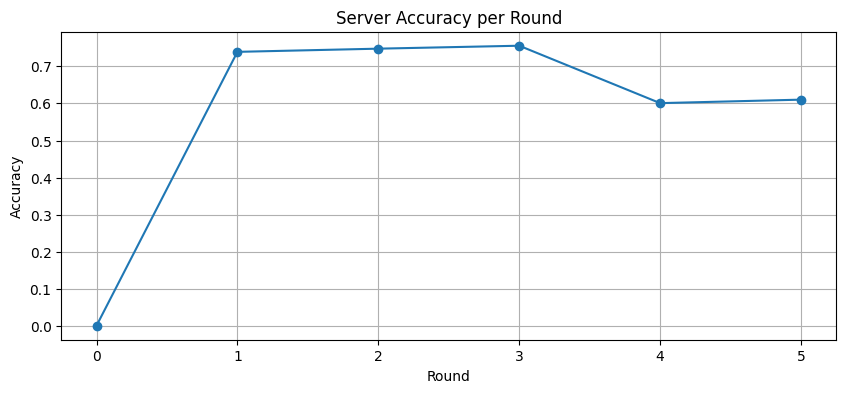

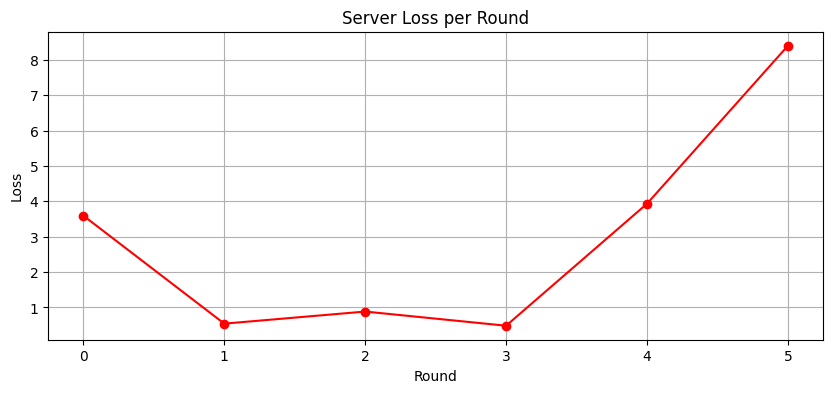

In [34]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
